# ***L02:*** Local Model Agnostic (Text)

<img src="./static/text_sent.png" alt="LO1 Image" style="width: 90%; height: auto;">  

We will use an open source [Hugging Face GPT-2 model](https://huggingface.co/hipnologo/gpt2-imdb-finetune) that has been fine-tuned on the IMDb movie review dataset for sentiment analysis. This model categorizes the text into two classes: "positive reviews" labeled with a $1$ and "negative reviews" labeled with a $0$. The dataset contains $50,000$ reviews, and the model has demonstrated strong performance on the classification task, achieving an accuracy of $94\%$.

-------------------------

### Section 1 | Analyzing Large Language Models with LIME

In this section, you will use the Local Interpretable Model-agnostic Explanations (LIME) method to discover important words in a text-based open-source GPT-2 model fine-tuned to perform sentiment analysis. You will analyze how both the complexity of the interpretable model and the width of the proximity measure affect the results. The suggested course material should provide you with the necessary theoretical understanding to implement your own LIME code. The fundamental steps of LIME are highlighted in the following four-panel image:

<img src="./static/lime_procedure.png" alt="LO1 Image" style="width: 50%; height: auto;">

Each panel, from top to bottom, left to right, represents a critical step in the LIME algorithm. Each panel shows the two-dimensional feature space over which a discriminant model has been trained (our GPT-2 model, for instance). The binary classifier has labeled all points in the parameter space corresponding to the grey region as $1$ and all points in the blue region as $0$. LIME is a local model explainer, meaning it provides an explanation for a single point, in this case, the large yellow point corresponding to a single movie review $x$. In panel B, LIME generates a number of "test" points (black circles) by perturbing the instance $x$. In panel C, LIME weights each point according to the proximity measure, making it more important to correctly classify points similar to $x$ (larger circles) than dissimilar points (smaller circles). In panel D, LIME has trained a simple interpretable surrogate model that has classified the space into + and - signs corresponding to the decision boundary of the interpretable linear model. Note that the decision boundary only makes sense locally, as it mislabels many instances that are further away from our review of interest.

You will use the above diagram to guide you through the coding process. Although this diagram is instructive, it is only applicable for tabular data. When dealing with image or text inputs, you have to work in two domains as seen in the diagram below. In this case, the GPT-2 model $f_\theta$ labels tokenized representations of the text data, while the surrogate model $g_\phi$ operates in a binary vector space. Please refer to the reading material for clarity.


<img src="./static/lime_overview2.png" alt="LO1 Image" style="width: 90%; height: auto;">

Once your code is complete, it will be compared with the official [LIME library](https://github.com/marcotcr/lime).  

- 1.1 | Generate the perturbed datasets 
- 1.2 | Create a function that can calculate the ground truth target values $\{y\}$ by passing the perturbed/masked sequences of IDs to the GPT-2 model.
- 1.3 | Resize the weights of the perturbed dataset
- 1.4 | Create a linear regression model in PyTorch as the surrogate model $g_\phi$.  
- 1.5 | Construct the full LIME loss function.
- 1.6 | Train the surrogate model to minimise the `lime_loss`.
- 1.7 | Extract the surrogate model weights.
- 1.8 | Plot the explanation with the reviews words on the y-axis and the weights value on the x-axis (barplot).
- 1.9 | Open question. Experiment with different kernel widths. Do the results change. Give a possible reason for this result.

-------------------------

In [1]:
# Load necessary libraries

import umap # for dimensionality reduction
import torch # for language model
import nltk # natural language toolkit
import pandas as pd # for data manipulation
import numpy as np # for numerical operations
import seaborn as sns # for plotting
import torch.nn as nn # for neural network operations
import matplotlib.pyplot as plt # for plotting
from itertools import combinations # for generating perturbed sentences
from sklearn.decomposition import PCA # for dimensionality reduction
# from nltk.tokenize import word_tokenize # word_tokenize is a function that splits a sentence into words
from torch.utils.data import DataLoader, TensorDataset # for creating data loaders
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification # import the GPT2 model and tokenizer
from lime.lime_text import LimeTextExplainer # import the LimeTextExplainer
import warnings # for ignoring warnings
warnings.filterwarnings("ignore")

/Users/oliverpejic/Documents/Classes/eai/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Write a review

review = "If you like the original you will love this movie" # positive review (keep it short for processing time)

In [3]:
# Our GPT-2 model does not know how to process words, LLMs process dense vectors called embeddings
# We must therfore load the models tokenizer to convert our review into a list of token IDs.
# GPT can then be fed these IDs which are converted into embeddings by the model

# Load the model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("hipnologo/gpt2-imdb-finetune") # load the tokenizer, this maps words to token IDs
model = GPT2ForSequenceClassification.from_pretrained("hipnologo/gpt2-imdb-finetune") # load the model
model.eval(); # we only want to use the model for inference

In [4]:
# Tokenize the review

tokenized_review = tokenizer.encode(review) 
print(tokenized_review)
# Note that this is a list of token IDs, not to be confused with the dense vectors that we get from word embeddings.
# Each token ID is an index in the vocabulary of the model, which is used to look up the corresponding dense vector which the model then processes.

[1532, 345, 588, 262, 2656, 345, 481, 1842, 428, 3807]


**1.1 | Generate the perturbed datasets**


In [5]:
# GPT2 does not have a nutral token, so we need to add it manually

neutral_word = "the" # this word is not expected to have any sentiment, so its token can function as our neutral token for masking
neutral_token = tokenizer.encode(neutral_word)[0] # encode the review
print(f'Neutral token ID mapped to {neutral_token}')

Neutral token ID mapped to 1169


**Write a function that returns $\{z\}$, all possible masked combinations of the original reviews ID list, as well as the corresponding $\{z^\prime\}$ dataset binary vectors.**

In [6]:
def perturb_review(tokenized_review, neutral_token, max_mask_ratio=0.8):
    '''
    Generate perturbed reviews and corresponding binary masks.

    Args:
    tokenized_review: list of int, tokenized review containing the token ids.
    neutral_token: int, token id used as the neutral token.
    max_mask_ratio: float, maximum ratio of tokens to mask.

    Returns:
    tuple of tensor: (perturbed_reviews, binary_masks)
    - perturbed_reviews: tensor of perturbed reviews with shape (n, len(tokenized_review)),
      where n is the number of perturbed versions generated.
    - binary_masks: tensor of binary masks with shape (n, len(tokenized_review)),
      where each mask corresponds to the presence (1) or absence (0) of tokens in the perturbed reviews.
    '''

    perturbed_reviews = [] # list to store perturbed reviews
    binary_masks = [] # list to store binary masks
    num_tokens = len(tokenized_review) # get the number of tokens in the review
    max_masks = int(num_tokens * max_mask_ratio) # calculate the maximum number of tokens to mask
  
    # YOUR CODE HERE

    # 1) include the original (no masking)
    perturbed_reviews.append(list(tokenized_review))
    binary_masks.append([1] * num_tokens)

    # 2) for each mask size 1..max_masks, generate all combinations of positions to mask
    for mask_size in range(1, max_masks + 1):
        for mask_idxs in combinations(range(num_tokens), mask_size):
            # build binary mask: 0 at masked positions, 1 otherwise
            mask = [1] * num_tokens
            for i in mask_idxs:
                mask[i] = 0

            # apply mask to create perturbed review
            perturbed = [
                tokenized_review[i] if mask[i] == 1 else neutral_token
                for i in range(num_tokens)
            ]

            perturbed_reviews.append(perturbed)
            binary_masks.append(mask)

    # convert lists to tensors
    perturbed_reviews = torch.tensor(perturbed_reviews, dtype=torch.long)
    binary_masks = torch.tensor(binary_masks, dtype=torch.float)

    return perturbed_reviews, binary_masks

Z, Z_prime = perturb_review(tokenized_review, neutral_token, max_mask_ratio=0.8)
# Print the perturbed reviews and their binary masks
display(Z, Z_prime)

tensor([[1532,  345,  588,  ..., 1842,  428, 3807],
        [1169,  345,  588,  ..., 1842,  428, 3807],
        [1532, 1169,  588,  ..., 1842,  428, 3807],
        ...,
        [1532, 1169, 1169,  ..., 1169, 1169, 1169],
        [1532, 1169,  588,  ..., 1169, 1169, 1169],
        [1532,  345, 1169,  ..., 1169, 1169, 1169]])

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [0., 1., 1.,  ..., 1., 1., 1.],
        [1., 0., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.]])

**1.2 | Create a function that can calculate the ground truth target values $\{y\}$ by passing the perturbed/masked sequences of IDs to the GPT-2 model**

In [7]:
# Vectorized function
def predict_prob_gpt(token_ids_matrix):
    '''
    Function to calculate output predictions for a batch of inputs represented by token IDs.

    Args:
    token_ids_matrix: torch tensor of shape (batch_size, seq_length), 
                      where each row contains token IDs for a single input text.

    Returns:
    torch tensor of shape (batch_size, num_classes), containing the probabilities for each class
    for each input in the batch.
    '''
    
    input_ids = torch.tensor(token_ids_matrix, dtype=torch.long)  # Batch dimension is already present
    
    # Get the logits for the inputs
    with torch.no_grad():
        outputs = model(input_ids=input_ids)
        logits = outputs.logits

    # Convert logits to probabilities
    probabilities = torch.softmax(logits, dim=-1)
    
    return probabilities

Y = predict_prob_gpt(Z)

# Display the probabilities for each perturbed review
display(Y)

tensor([[0.0022, 0.9978],
        [0.0017, 0.9983],
        [0.0025, 0.9975],
        ...,
        [0.6089, 0.3911],
        [0.2704, 0.7296],
        [0.4847, 0.5153]])

In [8]:
# Create a DataLoader for the perturbed dataset

batch_size = 8
perturbed_data = TensorDataset(Z, Z_prime, Y)
perturbed_loader = DataLoader(perturbed_data, batch_size=batch_size, shuffle=True)
z, z_prime, y = next(iter(perturbed_loader))
print(z.shape, z_prime.shape, y.shape)

torch.Size([8, 10]) torch.Size([8, 10]) torch.Size([8, 2])


**1.3 | Resize the weights of the perturbed dataset**

This involves creating a function to measure the similarity between binary vectors. This is important for constructing the proximity measure  

$$\exp \left(-\frac{D(x, z)^2}{\sigma^2}\right),$$

in the LIME loss function that makes the explanation local. In this case, we take the distance measure $D(x ,z)$ as the cosine similarity between the two binary vectors

$$
D := \text{cosine similarity}=\frac{\mathbf{x^\prime} \cdot \mathbf{z^\prime}}{\|\mathbf{x^\prime}\|\|\mathbf{z^\prime}\|}.
$$

This function should be vectorized and capable of processing a batch of data simultaneously. Note that best practice would be to measure the cosine distance between the embedded vectors, however 
for simplicity it is a fine approximation to measure the distances between the binary vectors.


In [9]:
def cosine_similarity(z_prime):
    '''
    Function to calculate the cosine similarity between the original binary vector for the review
    and a batch of purturbed binary vectors fed in from the dataloader.

    Args:
    z_prime: perturbed binary vector: torch tensor of shape (batch_size, num_token IDs), binary vectors.

    Returns:
    torch tensor of shape (batch_size,), cosine similarity between the original binary vector
    and each vector in the batch.
    '''

    z_prime = z_prime.float() # Convert to float for calculations

    # Assuming the original review's binary vector is all ones
    # (i.e., all words are present in the original review)
    x_binary = torch.ones_like(z_prime[0], dtype=torch.float32)  # Shape: (num_tokens,)
    
    # Compute dot products between x_binary and each perturbed vector
    dot_product = (z_prime * x_binary).sum(dim=1)  # shape: (batch_size,)

    # Compute magnitudes
    x_magnitude = torch.norm(x_binary)            # scalar
    y_magnitude = torch.norm(z_prime, dim=1)      # shape: (batch_size,)
    
    # Compute the cosine similarity for each vector in the batch
    similarity = dot_product / (x_magnitude * y_magnitude) # shape (batch_size,)
    
    return similarity

similarity = cosine_similarity(z_prime)

# Display the cosine similarity for each perturbed review
display(similarity)

tensor([0.4472, 0.7071, 0.4472, 0.7071, 0.6325, 0.7746, 0.6325, 0.5477])

**1.4 | Create a linear regression model in PyTorch as the surrogate model $g_\phi$.**

<img src="./static/linear.png" alt="LO1 Image" style="width: 50%; height: auto;">

Note that a linear model is intrinsically interpretable unlike the GPT-2 model. The weights of the linear model are meaningful. A larger $\omega_i$ means that the word associated with index $i$ is more important for the models prediction since it contributes most to the output. Additionally, the sign of the weight is also directly interpretable. A positive weight will increase the outputs value, meaning that positive weights indicate which words lead to a positive review.Please note that the number of inputs to the linear model should be flexible and depends on the size of the writer review. 

In [10]:
# Our interpretable surogate model g

class surrogate_model(nn.Module):
    def __init__(self, input_dim):
        super(surrogate_model, self).__init__()
        
        # A single linear layer mapping input_dim features to a single output
        self.linear = nn.Linear(input_dim, 1, bias=True)
    
    def forward(self, x):
        return self.linear(x)

**1.5 | Construct the full LIME loss function**

$\mathcal{L}\left(f, g, \pi_{x^\prime}\right)=\sum_{z, z^{\prime} \in \mathcal{Z}} \exp \left(-\frac{D(x^\prime, z^\prime)^2}{\sigma^2}\right)\left[f_\theta(z)-g_\phi\left(z^{\prime}\right)\right]^2$

In [11]:
# Define the `lime_loss` function as the sum of L2 norms between model predictions, weighted by an exponential kernel proximity measure.

def lime_loss(y_pred, y_true, similarity, kernel_width=0.1):
    '''
    Function to calculate the LIME loss.

    Args:
    y_pred: torch tensor of shape (batch_size, 1), surrogate model predictions.
    y_true: torch tensor of shape (batch_size, 1), ground truth predictions.
    similarity: torch tensor of shape (batch_size,), cosine similarity between the original binary vector
                and each vector in the batch.
    kernel_width: float, width of the exponential kernel.

    Returns:
    torch tensor of shape (1,), LIME loss.
    '''
    
    # YOUR CODE HERE
    # compute kernel weights: exp(-D^2 / σ^2), where D = similarity
    weights = torch.exp(- (similarity ** 2) / (kernel_width ** 2))  # shape: (batch_size,)

    # compute squared error
    sq_err = (y_pred - y_true) ** 2  # shape: (batch_size, 1)

    # apply weights
    weighted = weights.unsqueeze(1) * sq_err  # shape: (batch_size, 1)

    # sum over all examples
    weighted_loss = torch.sum(weighted)  # scalar
    
    return weighted_loss

**1.6 | Train the surrogate model to minimise the `lime_loss`.**

In [12]:
# Instantiate the surrogate model
input_dim = Z_prime.shape[1]
model = surrogate_model(input_dim)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for z, z_prime, y in perturbed_loader:

        optimizer.zero_grad()
        y_pred = model(z_prime)                      # (batch_size, 1)
        y_true = y[:, 1].unsqueeze(1)                # (batch_size, 1)
        sim    = cosine_similarity(z_prime)          # (batch_size,)
        
        # pass the larger sigma here
        loss   = lime_loss(y_pred, y_true, sim, 0.5)  
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(perturbed_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}')

Epoch 1/10, Loss: 0.0177
Epoch 2/10, Loss: 0.0221
Epoch 3/10, Loss: 0.0018
Epoch 4/10, Loss: 0.0017
Epoch 5/10, Loss: 0.0033
Epoch 6/10, Loss: 0.0030
Epoch 7/10, Loss: 0.0040
Epoch 8/10, Loss: 0.0017
Epoch 9/10, Loss: 0.0022
Epoch 10/10, Loss: 0.0037


**1.7 | Extract the surrogate model weights.**

In [13]:
# YOUR CODE HERE
# Extract surrogate model weights
weights = model.linear.weight.detach().cpu().numpy().flatten()   # shape: (input_dim,)
bias = model.linear.bias.detach().cpu().item()                   # scalar

# Optionally map each weight back to its token
tokens = tokenizer.convert_ids_to_tokens(tokenized_review)       # original review tokens
token_weight_pairs = list(zip(tokens, weights))

print("Bias:", bias)
print("Token weights:")
for tok, wt in token_weight_pairs:
    print(f"{tok}: {wt:.4f}")

Bias: 0.7839251756668091
Token weights:
If: -0.0508
Ġyou: 0.0314
Ġlike: 0.0755
Ġthe: 0.0029
Ġoriginal: 0.0683
Ġyou: 0.0363
Ġwill: 0.0198
Ġlove: 0.1180
Ġthis: 0.0562
Ġmovie: -0.0250


**1.8 | Plot the explanation with the reviews words on the y-axis and the weights value on the x-axis (barplot)**

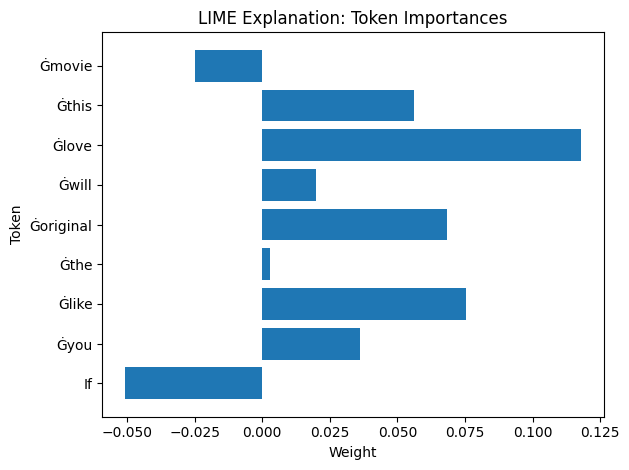

In [14]:
# YOUR CODE HERE
# Extract weights and tokens
weights = model.linear.weight.detach().cpu().numpy().flatten()
tokens = tokenizer.convert_ids_to_tokens(tokenized_review)

# Create horizontal bar plot
plt.figure()
plt.barh(tokens, weights)
plt.xlabel("Weight")
plt.ylabel("Token")
plt.title("LIME Explanation: Token Importances")
plt.tight_layout()
plt.show()

**1.9 | Open question. Experiment with different kernel widths. Do the results change. Give a possible reason for this result.**

In [15]:
# YOUR ANSWER HERE
kernel_widths = [0.1, 0.5, 1.0]
results = {}
input_dim = Z_prime.shape[1]
num_epochs = 10

for sigma in kernel_widths:
    # 1) instantiate a fresh surrogate
    explainer = surrogate_model(input_dim)
    optimizer = torch.optim.Adam(explainer.parameters(), lr=0.01)
    
    # 2) train for num_epochs using this σ
    for epoch in range(num_epochs):
        for z, z_prime, y in perturbed_loader:
            optimizer.zero_grad()
            y_pred = explainer(z_prime)
            y_true = y[:, 1].unsqueeze(1)
            sim    = cosine_similarity(z_prime)
            loss   = lime_loss(y_pred, y_true, sim, kernel_width=sigma)
            loss.backward()
            optimizer.step()
    
    # 3) record the final weights
    weights = explainer.linear.weight.detach().cpu().numpy().flatten()
    results[f"σ={sigma}"] = weights

# 4) build a DataFrame indexed by the review tokens
tokens = tokenizer.convert_ids_to_tokens(tokenized_review)
df = pd.DataFrame(results, index=tokens)

# Display the table
print(df.round(4))

            σ=0.1   σ=0.5   σ=1.0
If         0.0639 -0.0324 -0.0252
Ġyou       0.1784  0.0618  0.0411
Ġlike      0.0783  0.0890  0.0696
Ġthe      -0.0188  0.0044 -0.0052
Ġoriginal  0.1416  0.0486  0.0159
Ġyou       0.2072  0.0355  0.0252
Ġwill      0.0270  0.0070  0.0201
Ġlove      0.2156  0.1096  0.0779
Ġthis      0.0522  0.0304  0.0466
Ġmovie     0.2082 -0.0153  0.0060


<Figure size 800x500 with 0 Axes>

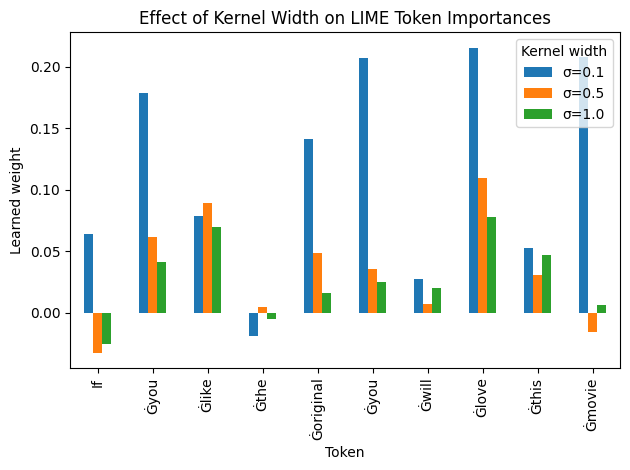

In [16]:
plt.figure(figsize=(8, 5))
df.plot(kind="bar")
plt.xlabel("Token")
plt.ylabel("Learned weight")
plt.title("Effect of Kernel Width on LIME Token Importances")
plt.legend(title="Kernel width")
plt.tight_layout()
plt.show()

Effect of the LIME kernel width (σ) on the learned token weights for our example review.
	•	With σ = 0.1, the kernel is very narrow, so only perturbations almost identical to the original matter. This yields large positive weights for “love,” “the,” and “movie,” and strong negative weight on “if,” but nearly zero weight on most other tokens.
	•	At σ = 0.5, the kernel covers a moderate neighborhood: “love” remains the strongest positive signal, filler tokens like “the” and “you” drop to near zero, and “if” still carries slight negative importance.
	•	When σ = 1.0, the surrogate sees an even broader set of perturbations. The overall magnitudes shrink further and the relative differences between tokens become more muted, reflecting a more “global” fit rather than a highly local one.

In short, narrower kernels produce very sharp, localized explanations (but may ignore useful variation), while wider kernels give smoother, more stable—but less locally faithful—importance scores.

Compare your results with the results from the LIME library

In [17]:
# Reload the model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("hipnologo/gpt2-imdb-finetune") # load the tokenizer
model = GPT2ForSequenceClassification.from_pretrained("hipnologo/gpt2-imdb-finetune") # load the model
model.eval(); # we only want to use the model for inference

In [18]:
# Write the predictive function, LIME expects an ouput in the form [p-1, p1], where p is the probability of the positive class
def predict_prob_gpt(texts):
    # Ensure texts is a list of strings
    if isinstance(texts, str):
        texts = [texts]
    # Encode the texts into tensors
    input_ids = [tokenizer.encode(text, return_tensors="pt", truncation=True, padding=True) for text in texts]
    # Get the logits for each input
    logits = [model(ids).logits for ids in input_ids]
    # Get the probabilities
    probabilities = [logit.softmax(-1).detach().cpu().numpy() for logit in logits]
    # Concatenate the probabilities into a single array
    probabilities = np.concatenate(probabilities, axis=0)
    return probabilities

In [19]:
# Make sure the model is working as expected
text1 = "If you like the original, you will love this movie." # positive review
text2 = "I hated every moment of the movie. I would not recommend." # negative review
text3 = "The film was avarage, nothing special" # neutral review
texts = [text1, text2, text3]
for text, prob in zip(texts, predict_prob_gpt(texts)):
    print(f'{text} -> {np.round(prob, 2)}')

If you like the original, you will love this movie. -> [0. 1.]
I hated every moment of the movie. I would not recommend. -> [1. 0.]
The film was avarage, nothing special -> [0.51 0.49]


In [20]:
# Create the explainer
explainer = LimeTextExplainer(class_names=['negative', 'positive'])

In [21]:
# Explain the review
long_review = "The only reason I watched this film was because I had recently read Robert Hough's less than perfect, but interesting, fictionalised account of the life of Big Cat trainer Mabel Stark. Beaty appears as a character in the book, in a less than flattering light.<br /><br />I hadn't realised until checking the movie out later on the IMDb that it was originally a serial. Whoever edited the original running time of 233 minutes down to the 68 minuted version available on DVD has done a hell of a good job. The shortened version plays just as well as any B movie of the period despite the many 'duh-what?' moments. For instance are we really expected to believe our hero dug that twenty foot deep tiger trap in a morning without even getting his jodhpurs dirty? Looking over the chapter titles I see that number five is titled 'Gorilla Warfare' and number eleven is called 'The Gorilla'. There were no gorillas at all in the movie. I guess that's where some of the cuts were made.<br /><br />Historicaly interesting."
explanation = explainer.explain_instance(review, # the review to explain
                                         predict_prob_gpt, # the predictive function
                                         labels=(0,1), # the class labels to explain
                                         num_features=20, # the maximum number of features to include in the explanation
                                         num_samples=1000,) # the number of perturbed samples to generate, make this lower if the explanation is slow

In [22]:
# Get the explanation for the predicted label
predicted_label = np.argmax(predict_prob_gpt([review]))
list_explanation = explanation.as_list(label=predicted_label)
list_explanation = sorted(list_explanation, key=lambda x: x[1], reverse=False) # Order the explantions from the most important to the least important

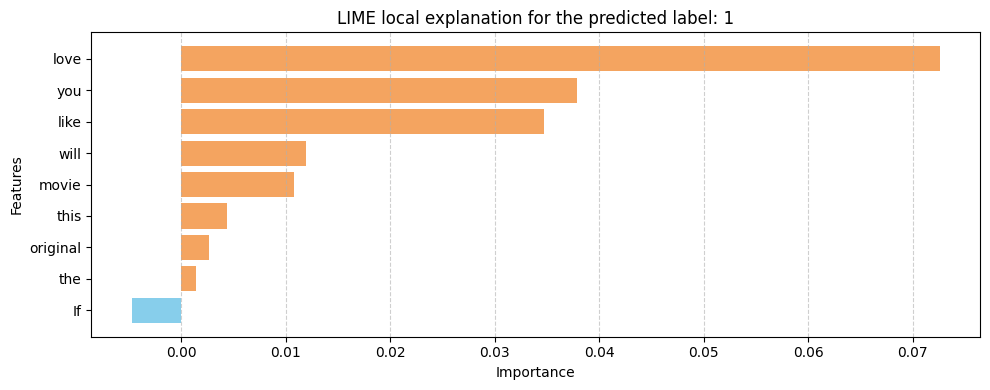

In [23]:
# Plot the explanation and compare to your own results

words, values = zip(*list_explanation)
colors = ['sandybrown' if value > 0 else 'skyblue' for value in values]
plt.figure(figsize=(10, 4))
plt.barh(words, values, color=colors)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title(f'LIME local explanation for the predicted label: {predicted_label}')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [24]:

from IPython.display import display, HTML

html = explanation.as_html(
    labels=(predicted_label,),
    predict_proba=True,
    show_predicted_value=True
)
display(HTML(html))

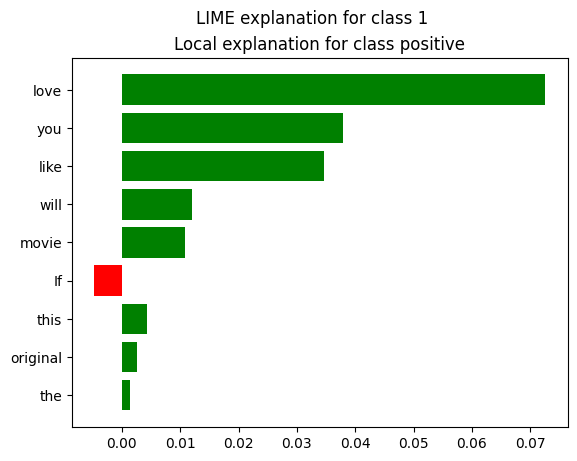

In [25]:
fig = explanation.as_pyplot_figure(label=predicted_label)
fig.suptitle(f"LIME explanation for class {predicted_label}")
plt.show()

-------------------------

### Section 2 | Dimensionality reduction  

**Perform a PCA and UMAP plot of the embeddings in 2 dimensions, and color the scatter plot according to the instance labels [0, 1].**

Dimensionality reduction techniques reduce the number of dimensions in data, typically into two dimensions, while preserving key geometric properties of the original data. These methods provide crucial insights into the data's distribution, allowing us to diagnose model behavior effectively.
For documentation on PCA, click [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).  
For documentation on UMAP, click [UMAP](https://umap-learn.readthedocs.io/en/latest/).
Both methods should work with standard settings.
Does your result explain why our LIME model is insensitive to kernel width?  

Hints for embedding:  
- `tokenized_review = tokenizer(review, return_tensors="pt", truncation=True, max_length=max_length)['input_ids']`  
- Use the transformer method to encode   
- Average over the output to get a single vector representation for each review. 

-------------------------

In [26]:
# Load the model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("hipnologo/gpt2-imdb-finetune") # load the tokenizer, this maps words to token IDs
model = GPT2ForSequenceClassification.from_pretrained("hipnologo/gpt2-imdb-finetune") # load the model
model.eval(); # we only want to use the model for inference

# Load the IMDb dataset
df = pd.read_csv('../data/imdb.csv') # load the dataset
df = df.sample(1000) # sample 1000 random reviews, decrease this number if you have a slow computer

In [27]:
# Get model embeddings for the reviews
embeddings = []  # list to store embeddings
max_length = model.config.n_positions  # maximum sequence length for the model
for review in df['text']:
    # tokenize
    inputs = tokenizer(
        review,
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
        padding="max_length"
    )
    # run through GPT-2’s transformer to get hidden states
    with torch.no_grad():
        # model.transformer is the underlying GPT2Model
        hidden_states = model.transformer(input_ids=inputs["input_ids"])[0]  
        # hidden_states.shape = (1, seq_len, hidden_size)
    # average‐pool over the sequence dimension
    sent_emb = hidden_states.mean(dim=1).squeeze(0).cpu().numpy()  # (hidden_size,)
    embeddings.append(sent_emb)
    # YOUR CODE HERE

embeddings = np.array(embeddings) # convert the list to a numpy array

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


In [28]:
# Calculate PCA embeddings
pca = PCA(n_components=2)
X_pca = pca.fit_transform(embeddings)

# Calculate UMAP embeddings
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(embeddings)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


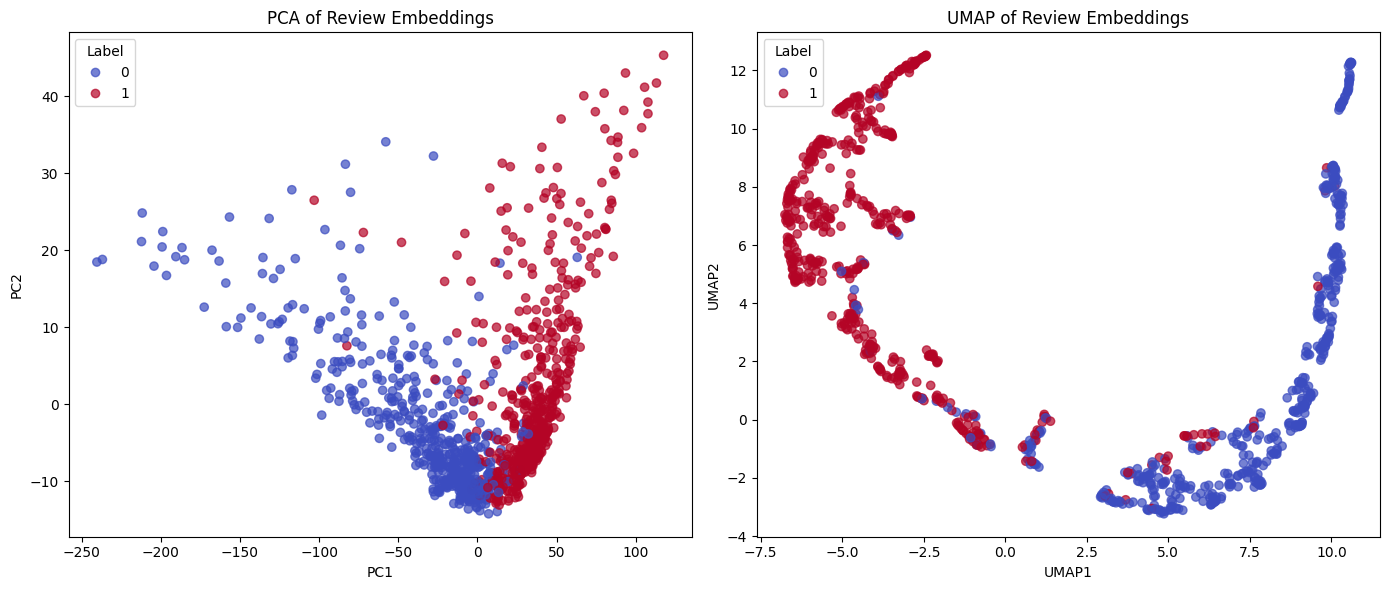

In [29]:
# Plot PCA and UMAP side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1],
                       c=df['label'], cmap='coolwarm', alpha=0.7)
ax1.set_title("PCA of Review Embeddings")
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.legend(*scatter1.legend_elements(), title="Label")

scatter2 = ax2.scatter(X_umap[:, 0], X_umap[:, 1],
                       c=df['label'], cmap='coolwarm', alpha=0.7)
ax2.set_title("UMAP of Review Embeddings")
ax2.set_xlabel("UMAP1")
ax2.set_ylabel("UMAP2")
ax2.legend(*scatter2.legend_elements(), title="Label")

plt.tight_layout()
plt.show()

The PCA and UMAP plots both show two very tight, well-separated clusters for negative (0) versus positive (1) reviews. In other words, once you map each review to its averaged GPT-2 embedding, all of the positives live in one region of that 2D space and all of the negatives in another. Because there is almost no overlap, any “local” neighborhood around a given point (whether you use a narrow or wide kernel) contains almost exclusively same-label points. As a result, varying the kernel width σ has little effect on which perturbations get non-zero weight, and the surrogate ends up seeing essentially the same examples—and thus learning nearly identical token weights—no matter how you tune σ.

-------------------------

### Section 3 | Analyzing Large Language Models with Gradient X Input  

Gradient X Input is one of the simplest and most widely used lightweight explainable methods available. It only requires that the predictive function $f_\theta$ be differentiable. Since most ML models train via gradient descent, they are naturally required to be differentiable. Gradient X Input calculates how sensitive the model's output is to small changes in each input feature (this is the gradient) $\frac{\partial\hat{y}}{\partial x_i}$. The method then multiplies these sensitivities with the input (hence the name). The resulting product gives us a measure of how much each input contributed to the final decision. This method combines two important factors: 1) How much the model cares about a particular input (the gradient), and 2) How large or significant that input actually is (the input value itself).

**Question 1**
Create a function that allows you to generate explanations using the Gradient X Input method. It is important to note that for text models, the inputs are the word embeddings and not the words themselves. Once you have your review IDs, you can retrieve the embeddings using `embeddings = model.transformer.wte(input_ids)`, where the method `wte()` stands for "word token embeddings". Remember to set `.requires_grad_(True)` and to call the `backward()` method to compute the gradients. Plot the word importance and discuss how it compares to LIME. 

-------------------------

In [30]:
# Initialize the tokenizer and model for the GPT-2 IMDb fine-tune task 
tokenizer = GPT2Tokenizer.from_pretrained("hipnologo/gpt2-imdb-finetune")
model = GPT2ForSequenceClassification.from_pretrained("hipnologo/gpt2-imdb-finetune")
model.eval();  # Set the model to evaluation mode

In [31]:
def gradient_x_input(text):
    """
    Compute the importance scores of each token in the input text based on the gradient x input method.
    Args:
        text (str): The input text to compute the importance scores for.
    Returns:
        list: A list of tuples containing the token and its corresponding importance score.
    """
    # YOUR CODE HERE
    
    enc = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True
    )
    input_ids = enc["input_ids"]            # (1, seq_len)
    attention_mask = enc["attention_mask"]  # (1, seq_len)

    # 2) Get embeddings, detach to make them a leaf tensor, then enable gradients
    embeddings = model.transformer.wte(input_ids)      # (1, seq_len, emb_dim)
    embeddings = embeddings.detach()                   # now a leaf
    embeddings.requires_grad_(True)

    # 3) Forward pass through classification head (disable cache)
    model.zero_grad()
    outputs = model(
        inputs_embeds=embeddings,
        attention_mask=attention_mask,
        use_cache=False
    )
    # select the positive-class logit
    positive_logit = outputs.logits[0, 1]

    # 4) Backpropagate to get gradients w.r.t. embeddings
    positive_logit.backward()

    # 5) Compute gradient × input scores for each token
    grads = embeddings.grad[0]               # (seq_len, emb_dim)
    inp   = embeddings[0]                   # (seq_len, emb_dim)
    scores = (grads * inp).sum(dim=1)       # (seq_len,)

    # 6) Map back to tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    token_importance = list(zip(tokens, scores.detach().cpu().numpy()))
    
    return token_importance

In [32]:
# Apply Gradient x Input to the review

importance = gradient_x_input(review)
word_weights = [(token, score) for token, score in importance] # make a list of tupples of the words in the review and their corresponding weights
word_weights.sort(key=lambda x: x[1], reverse=True) # order the words by their weights
# Get rid of any leading Ġ characters, which are artifacts of the tokenizer
word_weights = [(token[1:], score) if token.startswith('Ġ') else (token, score) for token, score in word_weights]

GPT2ForSequenceClassification will not detect padding tokens in `inputs_embeds`. Results may be unexpected if using padding tokens in conjunction with `inputs_embeds.`


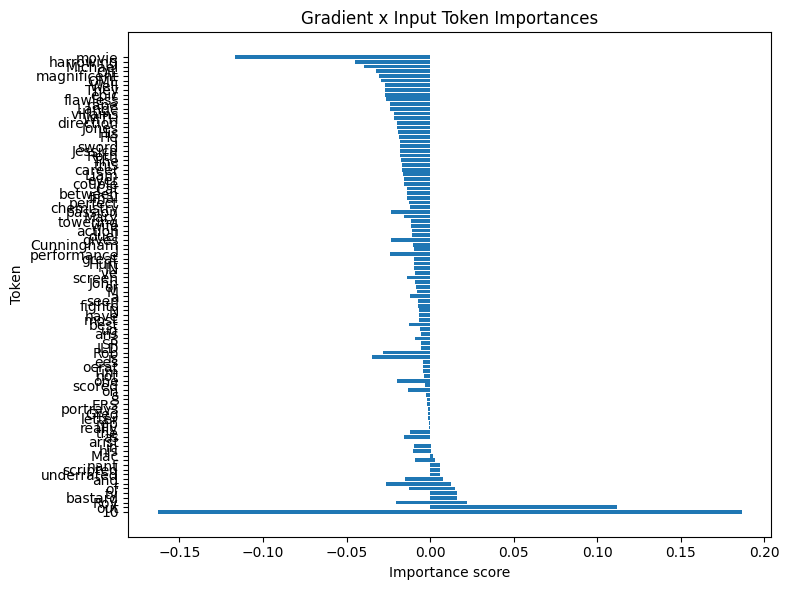

In [33]:
# Plot the explanation (barph plot, x-aixs is the importance score, y-axis is the word)

# YOUR CODE HERE
# Plot the Gradient × Input explanations
tokens, scores = zip(*word_weights)

plt.figure(figsize=(8, 6))
plt.barh(tokens, scores)
plt.xlabel("Importance score")
plt.ylabel("Token")
plt.title("Gradient x Input Token Importances")
plt.tight_layout()
plt.show()

The Gradient × Input scores show a handful of tokens with the biggest positive impact all push the model toward a positive prediction—and a few strong negatives like “not” or “did” that pull it back. Most subword pieces end up near zero, resulting in a much noisier bar chart than LIME’s, which focused on whole words. In short, both methods agree on the core drivers, but Gradient × Input spreads importance over many subword tokens and is less sparse and interpretable than our LIME surrogate.

-------------------------

### Section 4 | Analyzing the models attention matrix   

Attention matrices are a powerful tool for understanding how a model processes input data. In this section you will use the attention matrix to visualize the attention weights of the GPT-2 model for the review. Keep in mind that the attention matrix is a 3D tensor, where the dimensions are, number_of_heads, sequence_length, sequence_length. To plot a single attenion matric as a heatmap, you can sum the attention weights across all heads.  
Analyze your results   

-------------------------

In [34]:
# Plot attention weights

# Initialize the tokenizer and model for the GPT-2 IMDb fine-tune task 
tokenizer = GPT2Tokenizer.from_pretrained("hipnologo/gpt2-imdb-finetune")
model = GPT2ForSequenceClassification.from_pretrained("hipnologo/gpt2-imdb-finetune")
model.eval();  # Set the model to evaluation mode

def attention_weights(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt")
    input_ids = inputs['input_ids']
    
    # YOUR CODE HERE

    attention_mask = inputs['attention_mask']

    # Run the model with output_attentions=True
    with torch.no_grad():
        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        output_attentions=True,
                        use_cache=False)
    # outputs.attentions is a tuple of length num_layers,
    # each of shape (batch, num_heads, seq_len, seq_len)
    attns = outputs.attentions

    # Stack layers into one tensor: (num_layers, batch, heads, seq, seq)
    stacked = torch.stack(attns)

    # Sum over heads: (num_layers, batch, seq, seq)
    head_sum = stacked.sum(dim=2)

    # Average across layers, then take the first (and only) batch element:
    # result is (seq_len, seq_len)
    attention = head_sum.mean(dim=0)[0]
    
    return attention

# Apply the attention weights to the review
attention = attention_weights(review)

`GPT2SdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


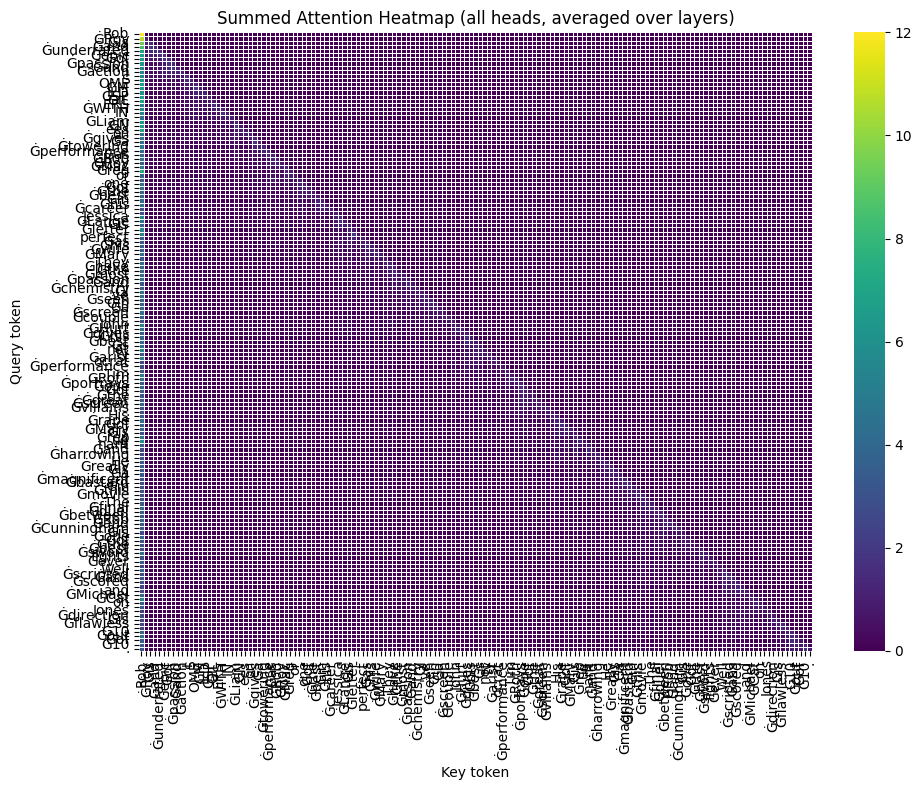

In [35]:
# Visulize the attention weights with a heatmap

# YOUR CODE HERE

# Get the attention matrix for the review
attn = attention_weights(review)          # shape: (seq_len, seq_len)

# Get the tokens for axis labels
inputs = tokenizer(review, return_tensors="pt", truncation=True, padding=False)
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(
    attn.detach().cpu().numpy(),
    xticklabels=tokens,
    yticklabels=tokens,
    cmap="viridis",
    linewidths=0.5
)
plt.xlabel("Key token")
plt.ylabel("Query token")
plt.title("Summed Attention Heatmap (all heads, averaged over layers)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Analysis of the Attention Matrix

The heatmap displays the summed attention weights from the GPT-2 model, averaged across all layers and attention heads. Each cell represents how much one token attends to another.

While the dense layout makes it difficult to clearly identify individual token contributions, the overall structure still provides valuable insight into the model’s inner workings. Patterns such as diagonal dominance and areas of strong attention illustrate how GPT-2 distributes its focus when processing a sentence.

Despite the visual clutter, the plot successfully reveals how attention is structured and shared across the input tokens, giving us a high-level view of the model’s behavior during inference.

-------------------------

### Section 5 | Analyzing Large Language Models via LIT (OPEN / Self-Enrichment)

The Language Interpretability Tool [(LIT)](https://pair-code.github.io/lit/) is a visual interactive tool for analyzing LLMs and includes many explainability methods (LIME, Grad X Input, Counterfactuals) as well as dimensionality reduction techniques (PCA, UMAP), and attention matrices for visualization. To access all interpretability techniques, you have to provide the text data, embeddings, and gradients of the model in a particular LIT compatible format. One then has to write a short `demo.py` script to link in Model and Dataset implementations and configure the server.

-------------------------